In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

from qililab import Experiment, build_platform
from qililab.pulse.pulse import Pulse
from qililab.pulse.pulse_schedule import PulseSchedule
from qililab.pulse.pulse_shape.gaussian import Gaussian

[Qibo 0.1.7|INFO|2022-10-04 11:20:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.1.7|WARNING|2022-10-04 11:20:17]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.


In [2]:
fname = os.path.abspath("")
os.environ["RUNCARDS"] = str(Path(fname) / "runcards")
os.environ["DATA"] = str(Path(fname) / "data")

In [32]:
# PARAMS

# qubit parameters in runcard
dimension = 10  # used for results, same as in runcard

amp = 1e-18
tmax = 200  # ns
tstep = 1e-2  # ns, same as runcard
# freq not defined -> qubit frequency is used

sigma = 0.12 * tmax
num_sigmas = tmax / sigma

In [33]:
# RUN CALCULATION
platform = build_platform(name="flux_qubit_simulator")

gaussian = Gaussian(num_sigmas=num_sigmas)
pulse = Pulse(amplitude=amp, duration=tmax, phase=0, start_time=0, pulse_shape=gaussian)

pulse_schedule = PulseSchedule()
pulse_schedule.add(pulse=pulse, port=0)

experiment = Experiment(platform=platform, sequences=pulse_schedule)

results = experiment.execute()

[qililab] [0.7.3|INFO|2022-10-04 11:52:15]: Building platform
INFO:qililab.config.config:Building platform


In [41]:
# RESULTS
result = results.results[0]

states = [result.psi0] + result.states
times = [0] + result.times


# Operators: populations
# Hilbert space contains only the qubit in its eigenbasis
init0 = qt.fock_dm(dimensions=dimension, n=0)
init1 = qt.fock_dm(dimensions=dimension, n=1)

probs0_l = []
probs1_l = []
for state in states:
    probs0_l.append(qt.expect(init0, state))
    probs1_l.append(qt.expect(init1, state))

probs0 = np.array(probs0_l)
probs1 = np.array(probs1_l)

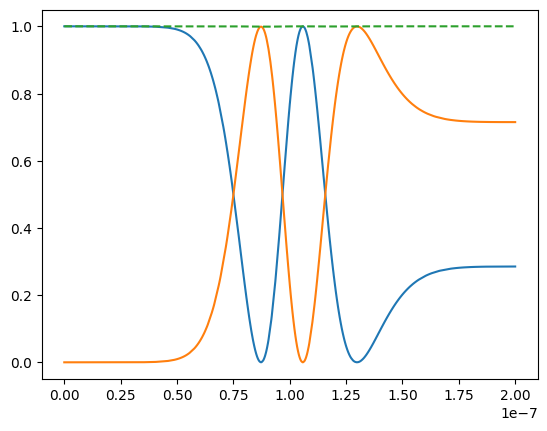

In [39]:
# PLOT
plt.figure()
plt.plot(times, probs0)
plt.plot(times, probs1)
plt.plot(times, probs0 + probs1, "--")

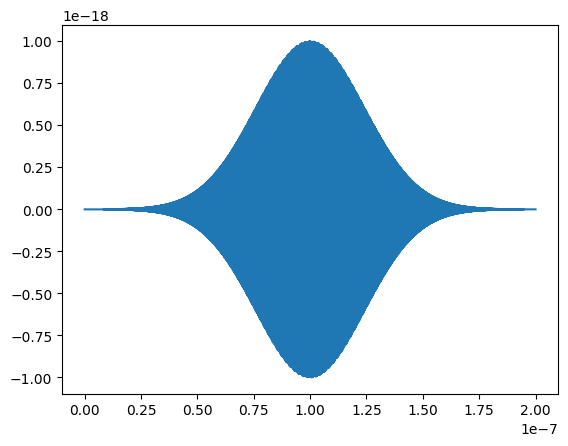

In [40]:
# Sanity check: plot pulse

ssc = experiment.execution.buses_execution.buses[0].system_control
waveform = ssc._evo.waveforms[0]

plt.figure()
plt.plot(times[:-1], waveform)